# Report: Ex1 - ZooScanNet in the cloud

## Tore Aadland

Prior works:
http://benanne.github.io/2015/03/17/plankton.html
https://www.kaggle.com/c/datasciencebowl/discussion

Training imagenet fast and cheaply: https://www.fast.ai/2018/04/30/dawnbench-fastai/

First lets load required modules:

In [1]:
import numpy as np
import random as rn
from dotenv import load_dotenv
import os
from skimage import io
from skimage.transform import resize, rotate
from skimage.util import pad
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model

import itertools

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Dropout, Flatten, Dense, Input, Concatenate, Reshape, Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from sklearn.metrics import confusion_matrix
# import tensorflow as tf

import datetime
import time
import threading
load_dotenv()

Using TensorFlow backend.


True

 Then seed the random number generators to make results reproducible:

In [2]:
rn.seed(42)
np.random.seed(42)

Lets load some example data to get started and add some data augmentation increase the size of the training data.

In [3]:
datafolder = os.getenv("DATAFOLDER")
outputfolder = os.getenv("OUTPUTFOLDER")
imgfolder = os.path.join(datafolder, 'MiniZoo','imgs')

In [44]:
EPOCHS = 50
BATCH_SIZE = 64

A helper function to train and save models:

In [7]:
def fit_and_save_model(name, model, train_gen, validation_gen, 
                       steps_per_epoch = 10, validation_steps=10, epochs=10, img_input=True):
    modeloutputfolder = os.path.join(outputfolder, name, datetime.datetime.now().strftime("%Y-%m-%d-%H-%M"))
    if not os.path.exists(modeloutputfolder):
        os.makedirs(modeloutputfolder)
    
    cbs=[ModelCheckpoint(filepath=os.path.join(modeloutputfolder,'model_fitted.h5'), verbose=1, save_best_only=True),
         EarlyStopping(monitor='val_loss', patience=10),
         CSVLogger(os.path.join(modeloutputfolder,'model_history.csv'), separator=',', append=False)]
         
    start_time = time.time()
    history = model.fit_generator(train_gen,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=validation_gen,
                             validation_steps=validation_steps,
                             epochs=epochs, 
                            callbacks=cbs)
    end_time = time.time()
    
    
    plot_model(model, 
           to_file=os.path.join(modeloutputfolder,'model_visualized.png'),
           show_shapes=True,
           show_layer_names=True)
    
    print("It has the following training history:")
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training data loss')
    plt.plot(history.history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training data accuracy')
    plt.plot(history.history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(name))
    
    plt.savefig(os.path.join(modeloutputfolder,'model_history.png'))
    plt.show()
    
    score = model.evaluate_generator(validation_gen, steps=validation_steps)
    print("It has the following performance:")
    summary = "Validation loss: {}\nValidation accuracy: {}\nTraining time: {}".format(score[0], score[1], end_time-start_time)
    print(summary)
    
    with open(os.path.join(modeloutputfolder,'model_score.txt'), 'w+') as f:
        f.write(summary)

    print("It has the following confusion matrix:")
    img_vals = []
    stat_vals = []
    y_vals = []
    for _ in range(validation_steps):
        x, y = next(validation_gen)
        if len(x) == 2:
            img_vals.append(x[0])
            stat_vals.append(x[1])
        else:
            img_vals.append(x)
        y_vals.append(y)
    if stat_vals:
        X_validation = [np.concatenate(img_vals), np.concatenate(stat_vals)]
    else:
        X_validation = [np.concatenate(img_vals)]
    y_target = np.concatenate(y_vals)
    y_predicted = np.argmax(model.predict(X_validation), axis= 1)
    y_true = np.argmax(y_target, axis= 1)
    cm = confusion_matrix(y_true, y_predicted)
    for i in range(len(cm)):
        cm[i,i] = 0
    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap="Greys")
    plt.xticks(range(max(y_true+1)))
    plt.yticks(range(max(y_true+1)))
    plt.title("Confusion matrix")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.savefig(os.path.join(modeloutputfolder,'model_confusion_matrix.png'))
    plt.show()
    
    if img_input:
        print("These are examples of misclassified features:")
        plt.figure(figsize=(15,15))
        #plt.subplot(3, 3, 1)
        plt.suptitle("Misclassified images - Model")
        poss_indexes = np.argwhere(y_predicted-y_true != 0)
        indexes = poss_indexes[:9]

        for i, index in enumerate(indexes.ravel()):
            plt.subplot(3, 3, i+1)
            plt.imshow(X_validation[0][index].reshape(224,224), cmap="Greys_r")
            plt.title("A {} misclassified as {}".format(y_true[index], y_predicted[index]))
        plt.savefig(os.path.join(modeloutputfolder,'model_misclassified_features.png'))
        plt.show()

Class distribution:

Now, lets make a small convolutional model:

In [10]:
# Copy paste from:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# Just to see if a simple model is better than pretrained network.

inputs_image = Input(shape=(224,224,1))

x0 = Conv2D(3, (3, 3), input_shape=(224, 224, 1),padding='same', activation='relu')(inputs_image)

x1 = Concatenate()([inputs_image,x0])
x1 = Conv2D(32, (3, 3), input_shape=(224, 224, 1), activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.1)(x1)

x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(x1)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.1)(x2)

x3 = Conv2D(32, (3, 3), padding='same', activation='relu')(x2)
x3 = MaxPooling2D(pool_size=(2, 2))(x3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.1)(x3)
x3 = Flatten()(x3)

x4 = Dense(1024, activation='relu')(x3)
outputs_image = Dense(1024, activation='relu')(x4)
predictions_image = Dense(NUMBER_LABELS, activation='softmax', name="output")(outputs_image)

In [11]:
model_images = Model(inputs=inputs_image, outputs=predictions_image)
model_images.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

Now we define a second model that analyses the imagestatistics:

In [12]:
inputs_stat = Input(shape=(3,))
x = Dense(32, activation='relu')(inputs_stat)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output_stat = Dense(64, activation='relu')(x)
predictions_stat = Dense(NUMBER_LABELS, activation='softmax', name="output")(output_stat)

In [13]:
model_stat = Model(inputs=inputs_stat, outputs=predictions_stat)
model_stat.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

Now I make a composite model:

In [14]:
x = Concatenate()([outputs_image, output_stat])
x = Dropout(0.2)(x)
predictions = Dense(NUMBER_LABELS, activation='softmax', name="output")(x)

composite_model = Model(inputs=[inputs_image, inputs_stat], outputs=predictions)

composite_model.compile(optimizer='rmsprop',
              loss="categorical_crossentropy", metrics=["accuracy"])

And fit the model to my training data:
TODO:
Make a multi-input mode that take both features_native and image data as input.
See: https://keras.io/getting-started/functional-api-guide/
Make custom datagenerator using: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [26]:
pretrained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(223,224,3))

# Nice guide for transfer learning:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# See:
# https://datascience.stackexchange.com/questions/30659/what-are-the-consequences-of-not-freezing-layers-in-transfer-learning
#pretrained_model.trainable = True

#for _ in range(5):
#    pretrained_model.layers.pop()

87916544/87910968 [==============================] - 2s 0us/step


The lower layer is:

In [27]:
print(pretrained_model.layers[-1])

In [35]:
inputs_image = Input(shape=(224,224,1))
x = Conv2D(3, kernel_size=(3,3), padding='same', activation='relu')(inputs_image)
x = pretrained_model(x)
x = Conv2D(1, (1,1), activation='relu')(x)
outputs_pretrained = Flatten()(x)
#outputs_pretrained = Flatten()(x)
#

x = Concatenate()([outputs_pretrained, output_stat])
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUMBER_LABELS, activation='softmax', name="output")(x)

composite_model_w_pretrained_model = Model(inputs=[inputs_image, inputs_stat], outputs=predictions)

composite_model_w_pretrained_model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

In [5]:
# Code from:
# https://github.com/keras-team/keras/issues/1638

class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self): # Py3
        with self.lock:
            return next(self.it)

    def next(self):     # Py2
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

Need some way of propagating the size of the image that is invariant to rotations. I am unhappy about the rigidity of the default ImageDataGenerator. I make my own custom data generator.

In [41]:
# See: http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate
# For additional possible transformations.
class MyGenerators(object):
    def __init__(self, path, val_fac=0.1, batch_size=16, validation_size=64, target_size=(224,224)):
        self.path = path
        self.val_fac = val_fac
        self.batch_size = batch_size
        self.validation_size = validation_size
        self.target_size = target_size
        
        self.labels = os.listdir(path)
        self.number_labels = len(self.labels)
        self.number_label_elements = {}
        self.label_paths = {}
        self.label_len = {}
        self.images = {}
        self.labels_to_classify = []
        for i, l in enumerate(self.labels):
            self.label_paths[i] = os.path.join(self.path, l)
            self.images[i] = (os.listdir(self.label_paths[i]))
            self.label_len[i] = len(self.images[i])
        self.test_split = int(val_fac*min(self.label_len.values()))
        self.val_split = int(2*val_fac*min(self.label_len.values()))
        self.val_steps = int(self.number_labels*(self.val_split-self.test_split)/self.batch_size)
        self.val_log = []
        self.training_log = []
    
    def make_square(self, image, mode='constant'):
        max_dim = max(image.shape)
        pads = ((int((max_dim-image.shape[0])/2),
                int((max_dim-image.shape[0])/2)),
                (int((max_dim-image.shape[1])/2),
                int((max_dim-image.shape[1])/2)))
        if (mode=='constant'):
            image = pad(image,pads , mode=mode, constant_values=255)
        else:
            image = pad(image,pads , mode=mode)
        return resize(image, (224,224), mode=mode)

    def augment_image(self, image):
        if(np.random.choice([True, False])):
            image = np.flip(image, axis=1)
        max_dim = max(image.shape)
        #pads = ((0, int((max_dim-image.shape[0]))),
        #            (0, int((max_dim-image.shape[1])/2)))
        #image = pad(image,pads , mode='constant', constant_values=255)
        #angle = np.random.random_integers(0,359)
        #resize_var = np.random.choice([True, False])
        #image = rotate(image, angle, resize=True, mode=np.random.choice(['symmetric', 'reflect', 'wrap', 'edge']))
        return self.make_square(image, mode='constant')

    def get_statistics(self, image):
        return (max(image.shape)/1024.0, min(image.shape)/1024.0, np.sum(image==255)/(1.0*np.product(image.shape)))

    def base_generator(self, augment_image, get_random_label_and_image):
        output_list = []
        output_labels = []
        while not len(output_list) == self.batch_size:
            random_label, random_image = next(get_random_label_and_image)
            output_labels.append(random_label)
            output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
        output_images = [io.imread(fp) for fp in output_list]
        output_statistics = [self.get_statistics(image) for image in output_images]
        output_augmented_images = [augment_image(image).reshape(224,224,1) for image in output_images]
        return ([np.stack(output_augmented_images), 
              np.stack(output_statistics)], 
              to_categorical(np.stack(output_labels), num_classes = self.number_labels))

    def training_image_selector(self):
        while True:
            random_label = np.random.choice( self.number_labels)
            random_image = np.random.choice(range(self.val_split, self.label_len[random_label]))
            self.training_log.append((random_label, random_image))
            yield (random_label, random_image)
    
    @threadsafe_generator
    def training_generator(self):
        it = self.training_image_selector()
        while True:
            yield self.base_generator(self.augment_image, it)

    def val_image_selector(self):
        while True:
            for random_label in range(self.number_labels):
                for random_image in range(self.test_split, self.val_split):
                    self.val_log.append((random_label, random_image))
                    yield (random_label, random_image)
        
    
    @threadsafe_generator
    def validation_generator(self):
        it = self.val_image_selector()
        while True:
            yield self.base_generator(self.make_square, it)    
    
    def test_image_selector(self):
        while True:
            for random_label in range(self.number_labels):
                for random_image in range(self.test_split):
                    yield (random_label, random_image)
    
    @threadsafe_generator
    def test_generator(self):
        it = self.test_image_selector()
        while True:
            yield self.base_generator(self.make_square, it)    


@threadsafe_generator            
def make_image_generator(gen):
    while True:
        res = next(gen)
        yield res[0][0], res[1]

@threadsafe_generator
def make_stat_generator(gen):
    while True:
        res = next(gen)
        yield res[0][1], res[1]

In [42]:
def visualize_generator(dategen):
    train_gen = dategen.training_generator()
    next(train_gen)
    validation_gen = dategen.validation_generator()

    NUMBER_LABELS = dategen.number_labels

    print("Number of validation images per class: ", dategen.val_split-dategen.test_split)
    print("Number of steps needed to go through all validation images: ", dategen.val_steps)
    
    print("Class distribution")
    plt.bar(dategen.label_len.keys(), dategen.label_len.values())
    plt.show()
    
    print("Visualize images of training generator, a quick check to see that input data is still sane:")
    plt.figure(figsize=(15,15))
    j = 1
    for i in range(9):
        (i, s), l = next(train_gen)
        for i_, s_, l_ in zip(i,s,l):
            if j > 9:
                break
            plt.subplot(3, 3, j)
            plt.imshow(i_[:,:,0], cmap="gray")
            plt.title("{}\n{}".format(np.argmax(l_), s_))
            j += 1
    plt.show()  
    
    print("Visualize images of validation generator, a quick check to see that input data is still sane:")
    plt.figure(figsize=(15,15))
    j = 1
    for i in range(9):
        (i, s), l = next(validation_gen)
        for i_, s_, l_ in zip(i,s,l):
            if j > 9:
                break
            plt.subplot(3, 3, j)
            plt.imshow(i_[:,:,0], cmap="gray")
            plt.title("{}\n{}".format(np.argmax(l_), s_))
            j += 1
    plt.show() 

Initialize data generator:

Number of validation images per class:  21
Number of steps needed to go through all validation images:  105
Class distribution


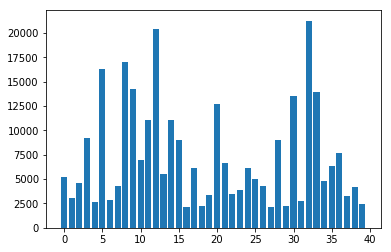

Visualize images of training generator, a quick check to see that input data is still sane:


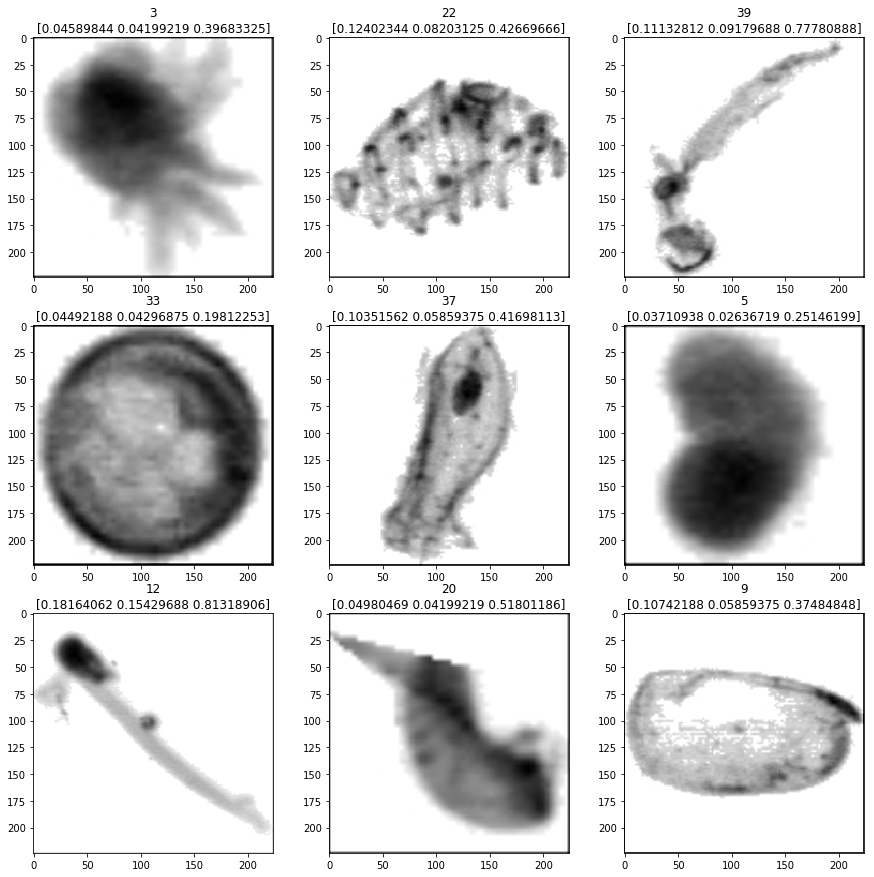

Visualize images of validation generator, a quick check to see that input data is still sane:


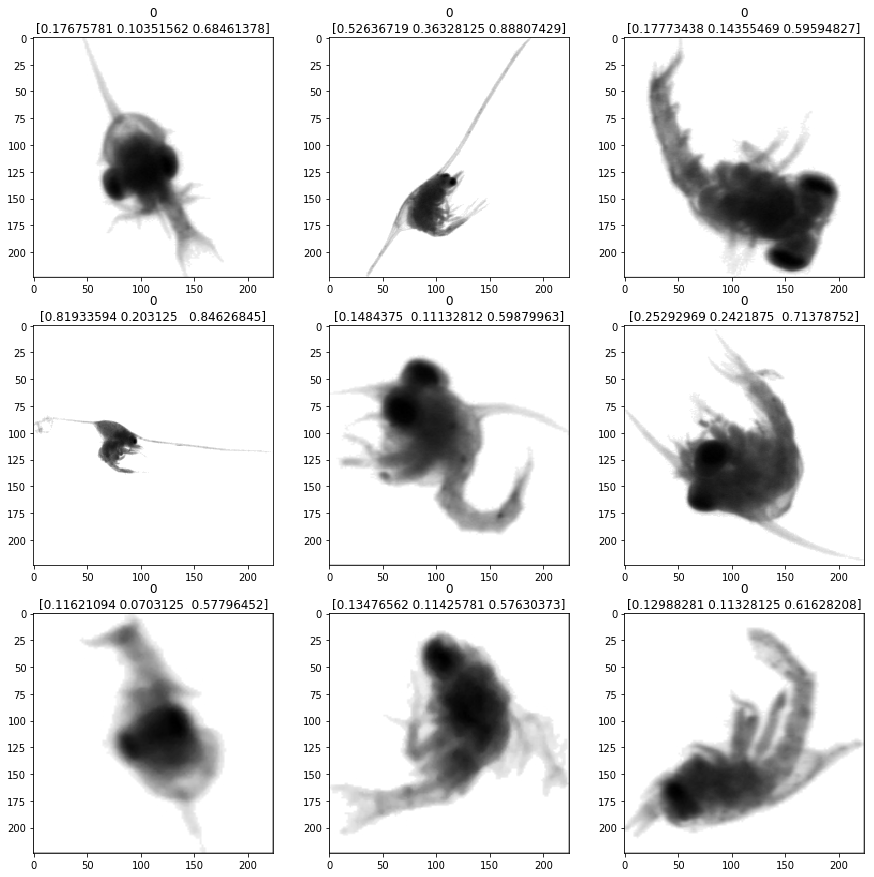

In [43]:
dategen = MyGenerators(imgfolder, batch_size=8, val_fac=0.01)
train_gen = dategen.training_generator()
validation_gen = dategen.validation_generator()
NUMBER_LABELS = dategen.number_labels
visualize_generator(dategen)

Epoch 1/50
210/210 [==============================] - 28s 132ms/step - loss: 2.5466 - acc: 0.2405 - val_loss: 2.2575 - val_acc: 0.2976

Epoch 00001: val_loss improved from inf to 2.25748, saving model to ../output/composite_model_w_pretrained_model/2019-02-21-13-03/model_fitted.h5
Epoch 2/50
210/210 [==============================] - 29s 137ms/step - loss: 2.4895 - acc: 0.2476 - val_loss: 2.4024 - val_acc: 0.2690

Epoch 00002: val_loss did not improve from 2.25748
Epoch 3/50
210/210 [==============================] - 27s 127ms/step - loss: 2.4163 - acc: 0.2696 - val_loss: 2.8392 - val_acc: 0.2274

Epoch 00003: val_loss did not improve from 2.25748
Epoch 4/50
210/210 [==============================] - 27s 128ms/step - loss: 2.3998 - acc: 0.2625 - val_loss: 2.3420 - val_acc: 0.2821

Epoch 00004: val_loss did not improve from 2.25748
Epoch 5/50
210/210 [==============================] - 28s 132ms/step - loss: 2.3672 - acc: 0.2940 - val_loss: 2.5351 - val_acc: 0.2417

Epoch 00005: val_loss

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following training history:


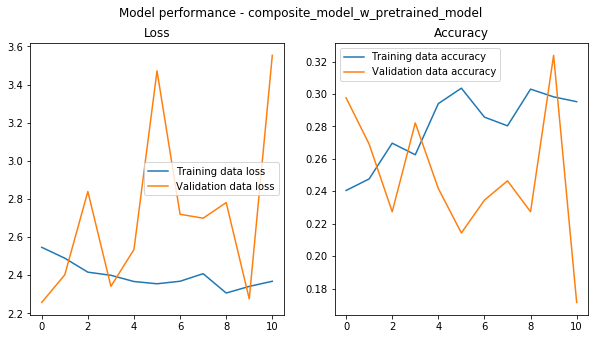

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following performance:
Validation loss: 3.5531736833708627
Validation accuracy: 0.17142857142857143
Training time: 300.4275152683258
It has the following confusion matrix:


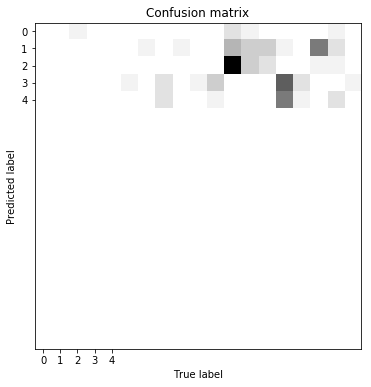

These are examples of misclassified features:


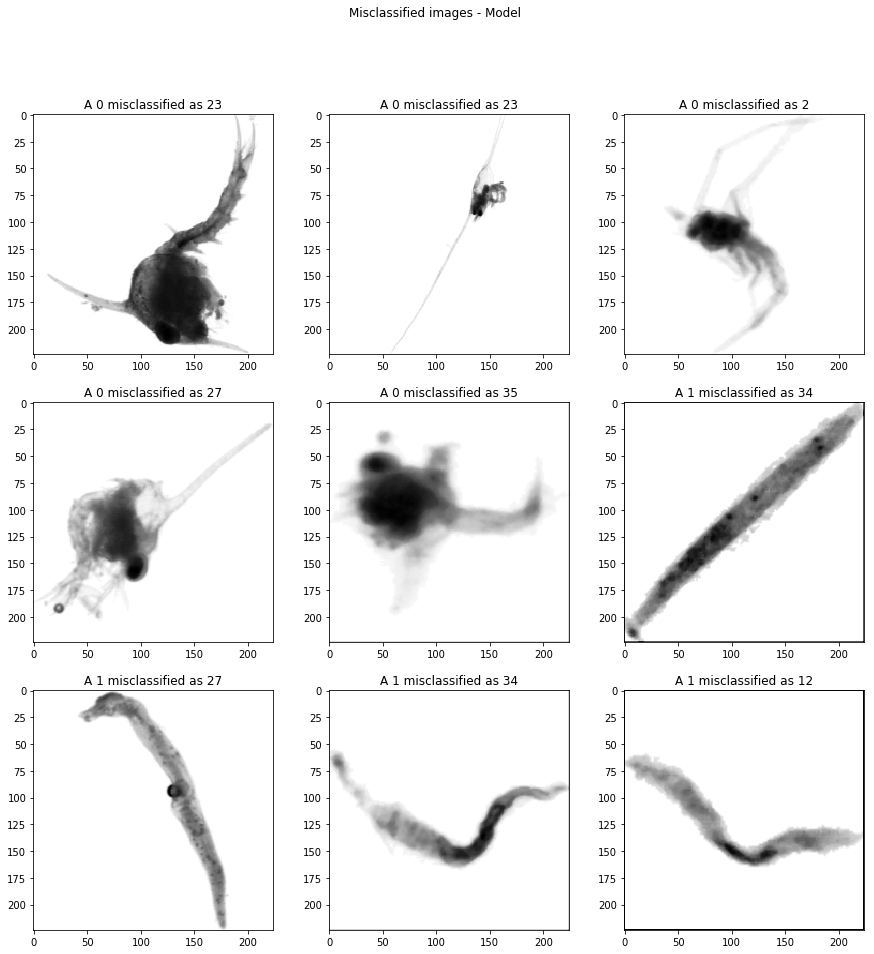

In [45]:
fit_and_save_model("composite_model_w_pretrained_model", composite_model_w_pretrained_model, train_gen, validation_gen,
                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)

In [46]:
#plt.hist([x for x, y in dategen.training_log])
#plt.show()

In [47]:
#plt.hist([x for x, y in dategen.val_log])
#plt.show()

Epoch 1/50
210/210 [==============================] - 24s 114ms/step - loss: 15.8015 - acc: 0.0196 - val_loss: 15.7151 - val_acc: 0.0250

Epoch 00001: val_loss improved from inf to 15.71514, saving model to ../output/composite_model/2019-02-21-13-08/model_fitted.h5
Epoch 2/50
210/210 [==============================] - 23s 110ms/step - loss: 15.8015 - acc: 0.0196 - val_loss: 15.7151 - val_acc: 0.0250

Epoch 00002: val_loss did not improve from 15.71514
Epoch 3/50
210/210 [==============================] - 25s 118ms/step - loss: 15.7343 - acc: 0.0238 - val_loss: 15.7151 - val_acc: 0.0250

Epoch 00003: val_loss did not improve from 15.71514
Epoch 4/50
210/210 [==============================] - 22s 106ms/step - loss: 15.7708 - acc: 0.0208 - val_loss: 15.6060 - val_acc: 0.0310

Epoch 00004: val_loss improved from 15.71514 to 15.60604, saving model to ../output/composite_model/2019-02-21-13-08/model_fitted.h5
Epoch 5/50
210/210 [==============================] - 25s 118ms/step - loss: 15.801

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following training history:


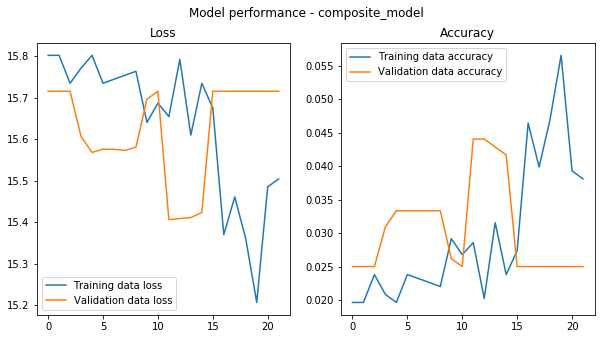

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following performance:
Validation loss: 15.715143015271142
Validation accuracy: 0.025
Training time: 506.19329833984375
It has the following confusion matrix:


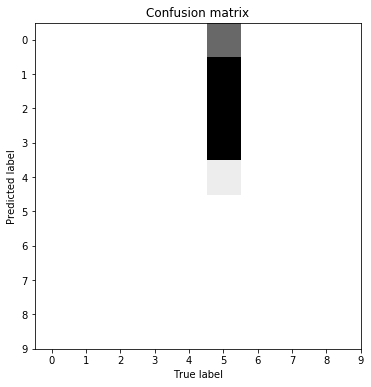

These are examples of misclassified features:


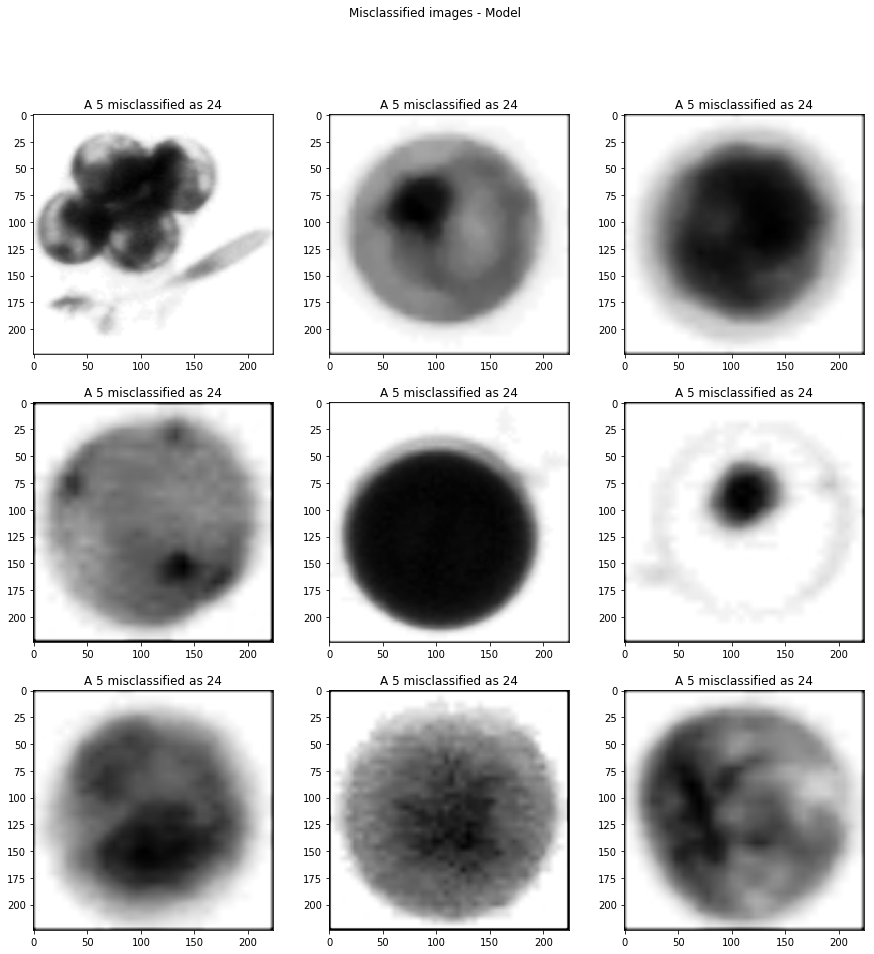

In [48]:
fit_and_save_model("composite_model", composite_model, train_gen, validation_gen,
                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)

Epoch 1/50
210/210 [==============================] - 39s 186ms/step - loss: 3.5334 - acc: 0.0619 - val_loss: 3.2333 - val_acc: 0.1250

Epoch 00001: val_loss improved from inf to 3.23333, saving model to ../output/model_stat/2019-02-21-13-17/model_fitted.h5
Epoch 2/50
210/210 [==============================] - 21s 100ms/step - loss: 3.0995 - acc: 0.1315 - val_loss: 2.8599 - val_acc: 0.1607

Epoch 00002: val_loss improved from 3.23333 to 2.85989, saving model to ../output/model_stat/2019-02-21-13-17/model_fitted.h5
Epoch 3/50
210/210 [==============================] - 23s 107ms/step - loss: 2.9581 - acc: 0.1333 - val_loss: 2.7525 - val_acc: 0.1571

Epoch 00003: val_loss improved from 2.85989 to 2.75246, saving model to ../output/model_stat/2019-02-21-13-17/model_fitted.h5
Epoch 4/50
210/210 [==============================] - 21s 99ms/step - loss: 2.9061 - acc: 0.1470 - val_loss: 2.6889 - val_acc: 0.2167

Epoch 00004: val_loss improved from 2.75246 to 2.68886, saving model to ../output/m

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following training history:


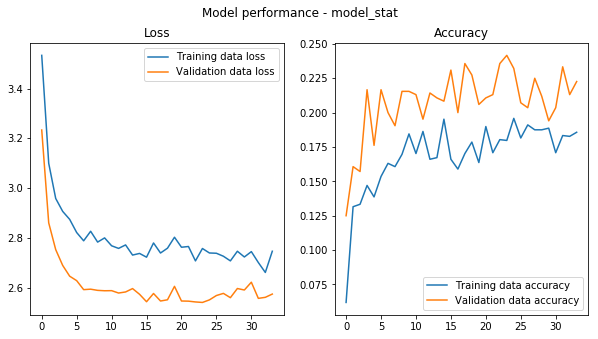

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following performance:
Validation loss: 2.5736852810496376
Validation accuracy: 0.2226190476190476
Training time: 725.5949766635895
It has the following confusion matrix:


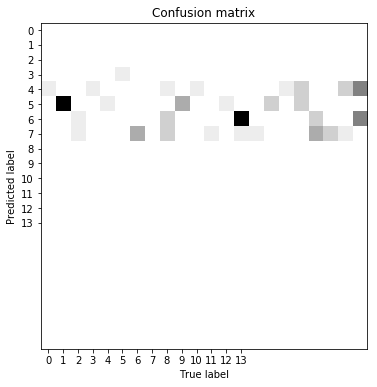

In [49]:
fit_and_save_model("model_stat", model_stat, make_stat_generator(train_gen), make_stat_generator(validation_gen),
                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS, img_input=False)

Epoch 1/50
210/210 [==============================] - 41s 195ms/step - loss: 15.5389 - acc: 0.0357 - val_loss: 15.7151 - val_acc: 0.0250

Epoch 00001: val_loss improved from inf to 15.71514, saving model to ../output/model_images/2019-02-21-13-29/model_fitted.h5
Epoch 2/50
210/210 [==============================] - 21s 98ms/step - loss: 15.6112 - acc: 0.0310 - val_loss: 15.3889 - val_acc: 0.0452

Epoch 00002: val_loss improved from 15.71514 to 15.38894, saving model to ../output/model_images/2019-02-21-13-29/model_fitted.h5
Epoch 3/50
210/210 [==============================] - 23s 110ms/step - loss: 15.3122 - acc: 0.0500 - val_loss: 15.4081 - val_acc: 0.0440

Epoch 00003: val_loss did not improve from 15.38894
Epoch 4/50
210/210 [==============================] - 20s 96ms/step - loss: 15.5137 - acc: 0.0375 - val_loss: 15.4081 - val_acc: 0.0440

Epoch 00004: val_loss did not improve from 15.38894
Epoch 5/50
210/210 [==============================] - 20s 94ms/step - loss: 15.6000 - acc: 

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following training history:


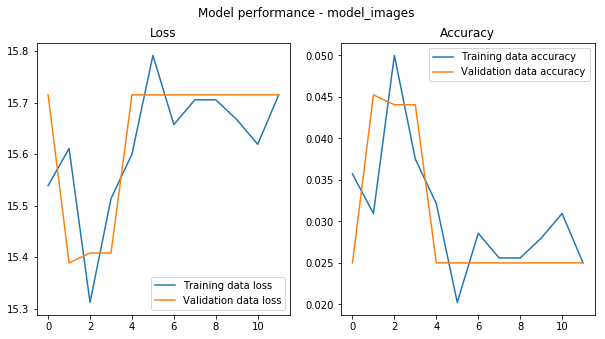

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following performance:
Validation loss: 15.715143015271142
Validation accuracy: 0.025
Training time: 270.5307502746582
It has the following confusion matrix:


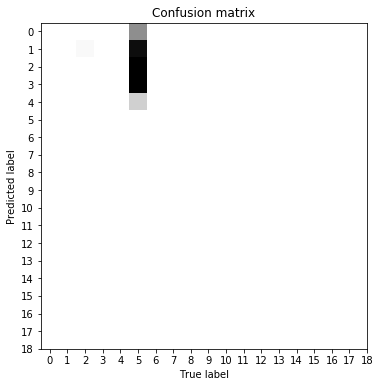

These are examples of misclassified features:


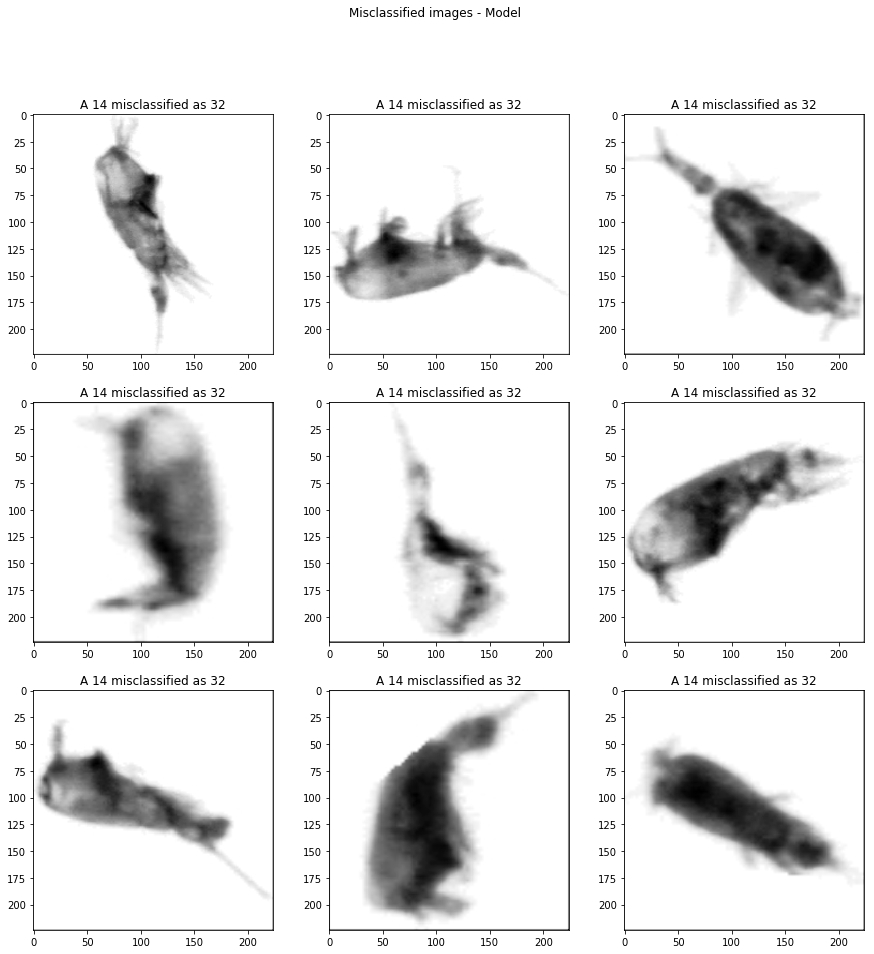

In [50]:
fit_and_save_model("model_images", model_images, make_image_generator(train_gen), make_image_generator(validation_gen),
                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)

In [51]:
class MySecondGenerators(MyGenerators):
    def augment_image(self, image):
        if(np.random.choice([True, False])):
            image = np.flip(image, axis=1)
        max_dim = max(image.shape)
        #pads = ((0, int((max_dim-image.shape[0]))),
        #            (0, int((max_dim-image.shape[1])/2)))
        #image = pad(image,pads , mode='constant', constant_values=255)
        #angle = np.random.random_integers(0,359)
        #resize_var = np.random.choice([True, False])
        #image = rotate(image, angle, resize=True, mode=np.random.choice(['symmetric', 'reflect', 'wrap', 'edge']))
        return self.make_square(image, mode='symmetric')
    
    def make_square(self, image, mode='symmetric'):
        if max(image.shape) > 224:
            max_dim = max(image.shape)
            pads = ((int((max_dim-image.shape[0])/2),
                    int((max_dim-image.shape[0])/2)),
                    (int((max_dim-image.shape[1])/2),
                    int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=255)
            else:
                image = pad(image,pads , mode=mode)
            return resize(image, (224,224), mode=mode)
        else:
            max_dim = 224
            pads = ((0, int((max_dim-image.shape[0]))),
                    (0, int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=255)
            else:
                image = pad(image,pads , mode=mode)
            return resize(image, (224,224), mode=mode)

Number of validation images per class:  21
Number of steps needed to go through all validation images:  13
Class distribution


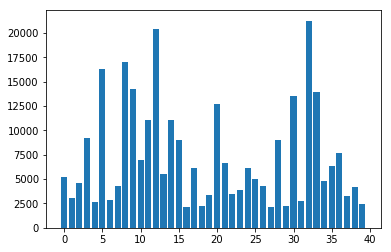

Visualize images of training generator, a quick check to see that input data is still sane:


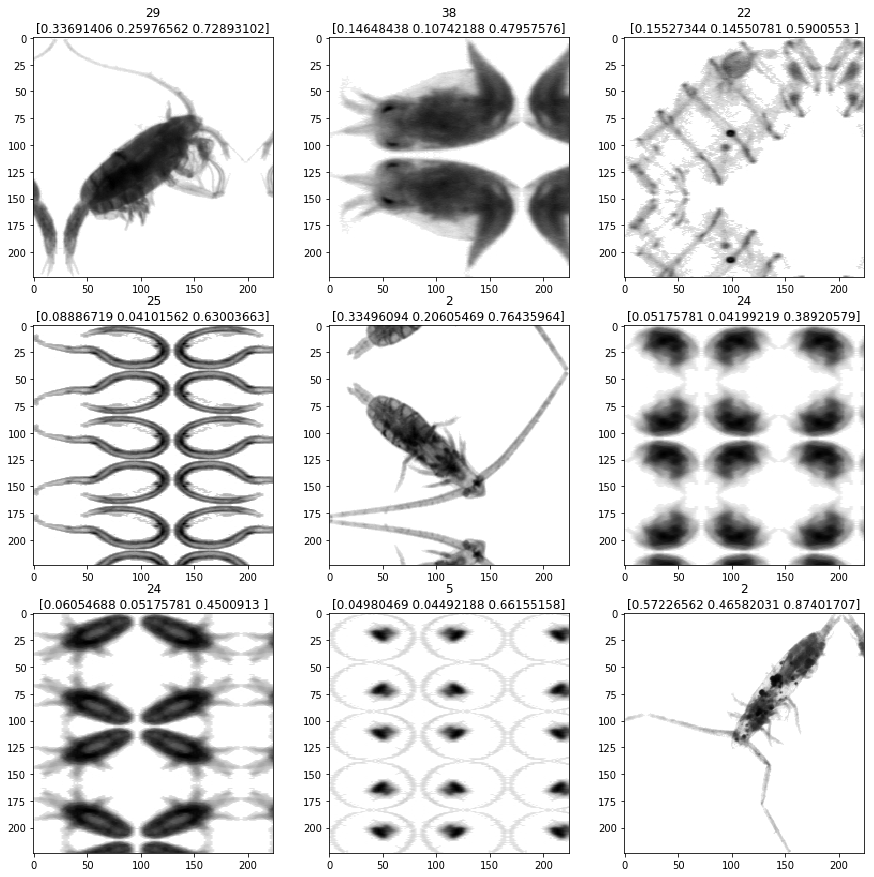

Visualize images of validation generator, a quick check to see that input data is still sane:


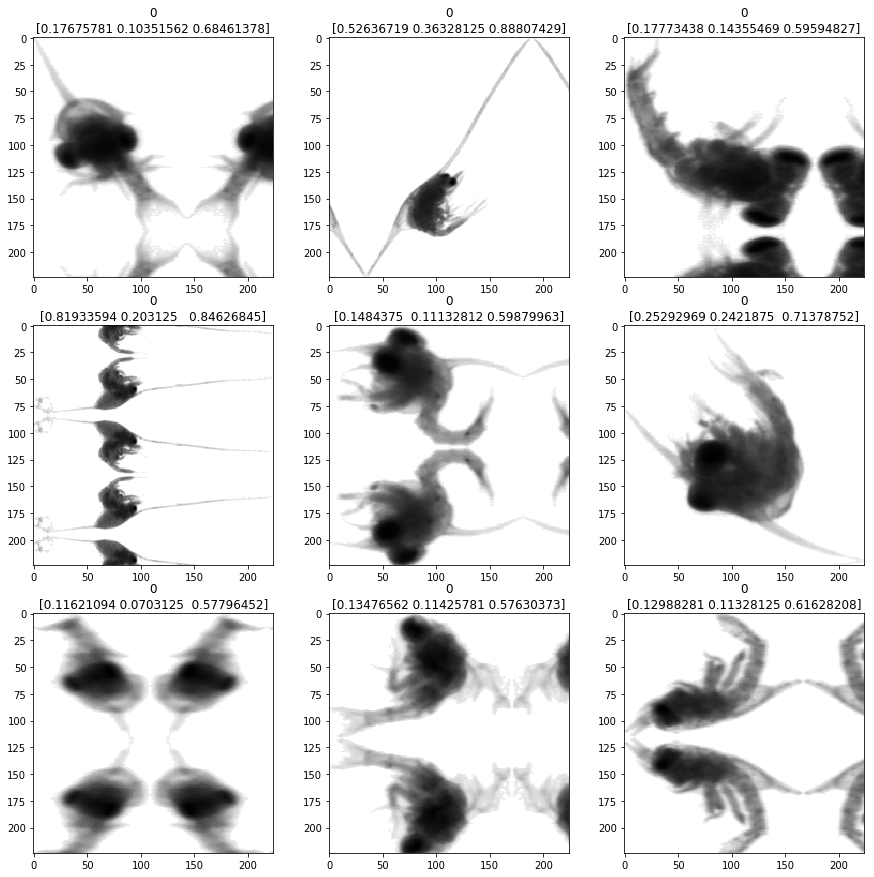

In [52]:
dategen = MySecondGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.01)
train_gen = dategen.training_generator()
validation_gen = dategen.validation_generator()
NUMBER_LABELS = dategen.number_labels
visualize_generator(dategen)

Epoch 1/50
26/26 [==============================] - 18s 690ms/step - loss: 2.4020 - acc: 0.3101 - val_loss: 3.4215 - val_acc: 0.1611

Epoch 00001: val_loss improved from inf to 3.42147, saving model to ../output/composite_model_w_pretrained_model/2019-02-21-13-34/model_fitted.h5
Epoch 2/50
26/26 [==============================] - 18s 698ms/step - loss: 2.2097 - acc: 0.3245 - val_loss: 3.0485 - val_acc: 0.2103

Epoch 00002: val_loss improved from 3.42147 to 3.04846, saving model to ../output/composite_model_w_pretrained_model/2019-02-21-13-34/model_fitted.h5
Epoch 3/50
26/26 [==============================] - 19s 719ms/step - loss: 2.0682 - acc: 0.3576 - val_loss: 3.0352 - val_acc: 0.2115

Epoch 00003: val_loss improved from 3.04846 to 3.03516, saving model to ../output/composite_model_w_pretrained_model/2019-02-21-13-34/model_fitted.h5
Epoch 4/50
26/26 [==============================] - 18s 691ms/step - loss: 2.0831 - acc: 0.3684 - val_loss: 1.9312 - val_acc: 0.3894

Epoch 00004: val_l

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following training history:


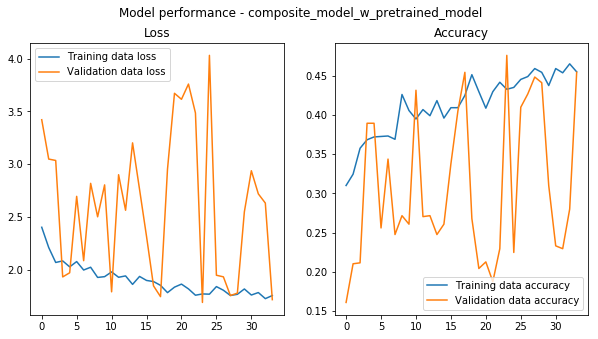

It has the following performance:
Validation loss: 1.7196637988090515
Validation accuracy: 0.4519230769230769
Training time: 597.7569000720978
It has the following confusion matrix:


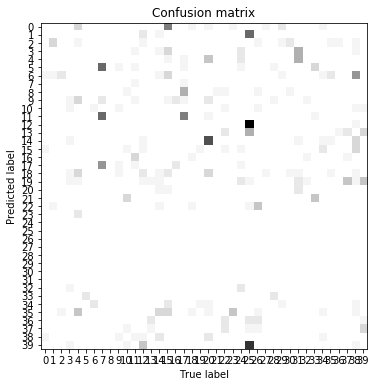

These are examples of misclassified features:


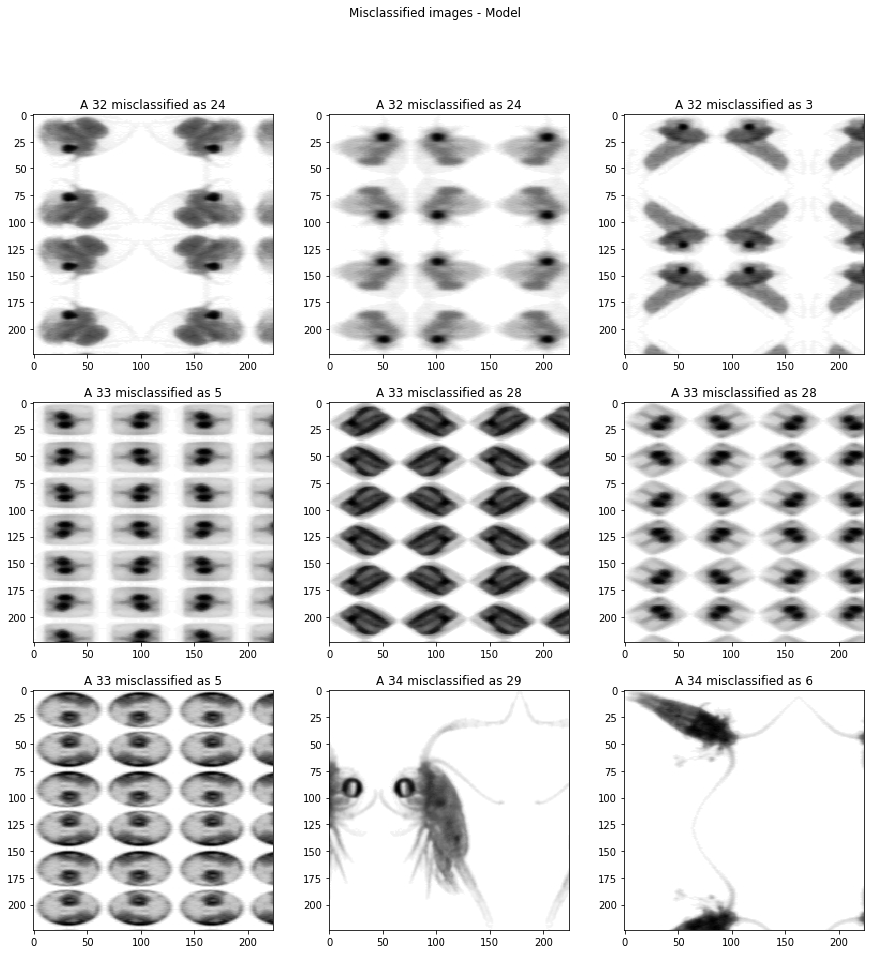

In [53]:
fit_and_save_model("composite_model_w_pretrained_model", composite_model_w_pretrained_model, train_gen, validation_gen,
                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)

Epoch 1/50
26/26 [==============================] - 17s 638ms/step - loss: 15.4319 - acc: 0.0421 - val_loss: 15.4209 - val_acc: 0.0433

Epoch 00001: val_loss improved from inf to 15.42091, saving model to ../output/composite_model/2019-02-21-13-44/model_fitted.h5
Epoch 2/50
26/26 [==============================] - 16s 615ms/step - loss: 15.5282 - acc: 0.0361 - val_loss: 15.6338 - val_acc: 0.0300

Epoch 00002: val_loss did not improve from 15.42091
Epoch 3/50
26/26 [==============================] - 17s 653ms/step - loss: 15.4401 - acc: 0.0421 - val_loss: 15.5950 - val_acc: 0.0325

Epoch 00003: val_loss did not improve from 15.42091
Epoch 4/50
26/26 [==============================] - 16s 616ms/step - loss: 15.5369 - acc: 0.0361 - val_loss: 15.5369 - val_acc: 0.0361

Epoch 00004: val_loss did not improve from 15.42091
Epoch 5/50
26/26 [==============================] - 16s 612ms/step - loss: 15.5661 - acc: 0.0343 - val_loss: 15.7113 - val_acc: 0.0252

Epoch 00005: val_loss did not improv

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following training history:


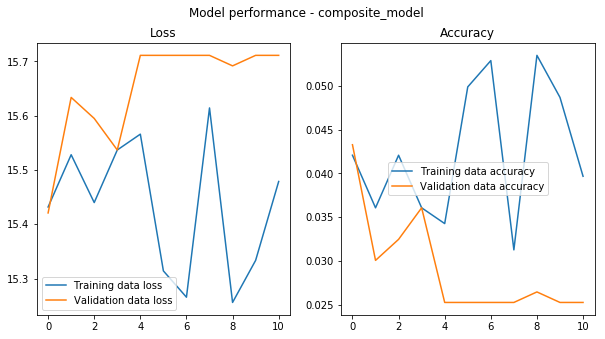

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following performance:
Validation loss: 15.711268498347355
Validation accuracy: 0.025240384615384616
Training time: 173.95794582366943
It has the following confusion matrix:


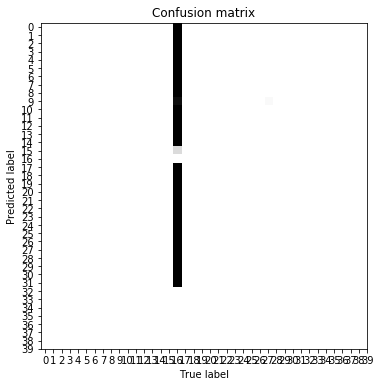

These are examples of misclassified features:


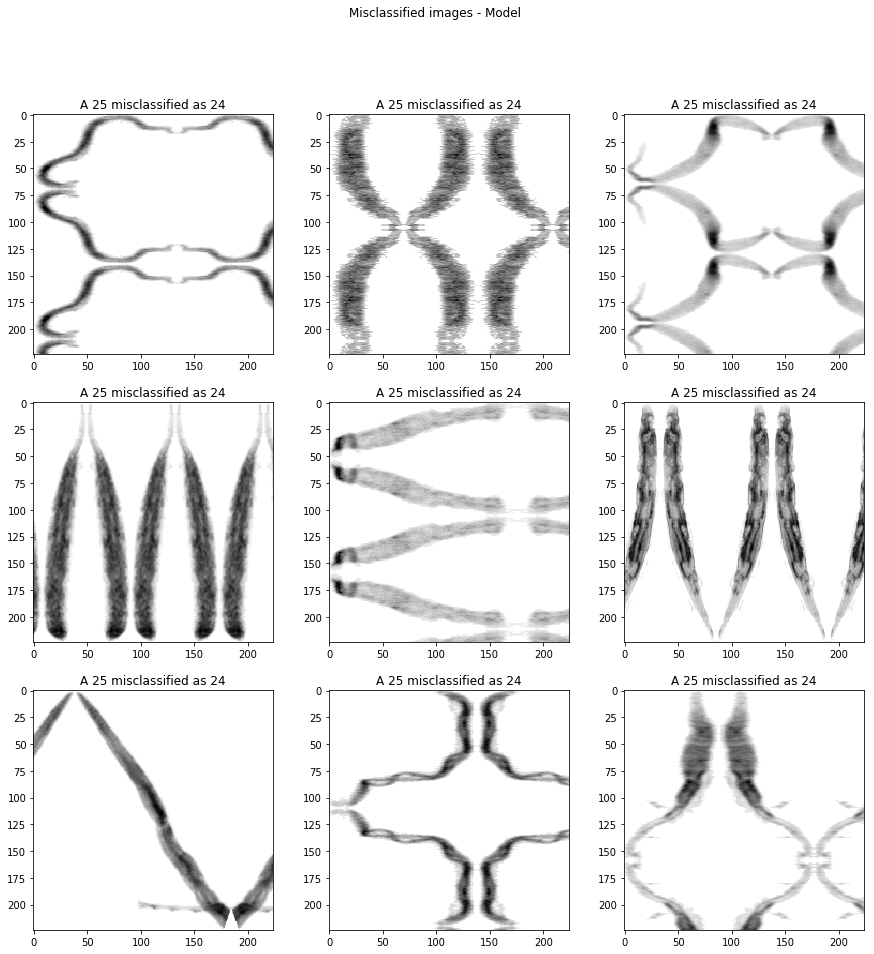

In [54]:
fit_and_save_model("composite_model", composite_model, train_gen, validation_gen,
                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)

Epoch 1/50
26/26 [==============================] - 15s 582ms/step - loss: 2.6729 - acc: 0.2019 - val_loss: 2.5700 - val_acc: 0.2260

Epoch 00001: val_loss improved from inf to 2.56996, saving model to ../output/model_stat/2019-02-21-13-47/model_fitted.h5
Epoch 2/50
26/26 [==============================] - 15s 578ms/step - loss: 2.6446 - acc: 0.2067 - val_loss: 2.5402 - val_acc: 0.2440

Epoch 00002: val_loss improved from 2.56996 to 2.54022, saving model to ../output/model_stat/2019-02-21-13-47/model_fitted.h5
Epoch 3/50
26/26 [==============================] - 14s 547ms/step - loss: 2.6219 - acc: 0.2043 - val_loss: 2.5444 - val_acc: 0.2308

Epoch 00003: val_loss did not improve from 2.54022
Epoch 4/50
26/26 [==============================] - 15s 592ms/step - loss: 2.5494 - acc: 0.2260 - val_loss: 2.5075 - val_acc: 0.2380

Epoch 00004: val_loss improved from 2.54022 to 2.50747, saving model to ../output/model_stat/2019-02-21-13-47/model_fitted.h5
Epoch 5/50
26/26 [=====================

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following training history:


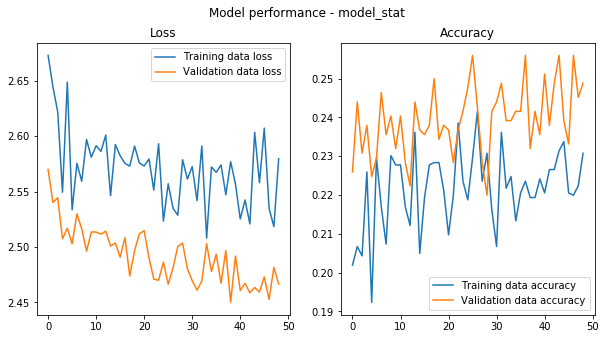

It has the following performance:
Validation loss: 2.4628797494448147
Validation accuracy: 0.24759615384615385
Training time: 703.9604260921478
It has the following confusion matrix:


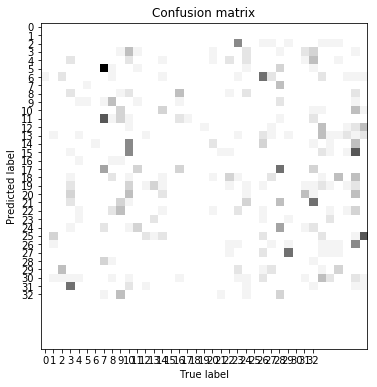

In [55]:
fit_and_save_model("model_stat", model_stat, make_stat_generator(train_gen), make_stat_generator(validation_gen),
                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS, img_input=False)

In [56]:
fit_and_save_model("model_images", model_images, make_image_generator(train_gen), make_image_generator(validation_gen),
                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)

Epoch 1/50
26/26 [==============================] - 15s 581ms/step - loss: 15.7405 - acc: 0.0234 - val_loss: 15.8663 - val_acc: 0.0156

Epoch 00001: val_loss improved from inf to 15.86625, saving model to ../output/model_images/2019-02-21-13-59/model_fitted.h5
Epoch 2/50
26/26 [==============================] - 15s 571ms/step - loss: 15.6822 - acc: 0.0270 - val_loss: 15.8663 - val_acc: 0.0156

Epoch 00002: val_loss improved from 15.86625 to 15.86625, saving model to ../output/model_images/2019-02-21-13-59/model_fitted.h5
Epoch 3/50
26/26 [==============================] - 17s 669ms/step - loss: 15.7984 - acc: 0.0198 - val_loss: 15.7113 - val_acc: 0.0252

Epoch 00003: val_loss improved from 15.86625 to 15.71127, saving model to ../output/model_images/2019-02-21-13-59/model_fitted.h5
Epoch 4/50
26/26 [==============================] - 16s 618ms/step - loss: 15.6532 - acc: 0.0288 - val_loss: 15.7113 - val_acc: 0.0252

Epoch 00004: val_loss did not improve from 15.71127
Epoch 5/50
26/26 [=

KeyboardInterrupt: 